<h1>Processing flow</h1>

In [1]:
%pylab notebook
import cv2

Populating the interactive namespace from numpy and matplotlib


[189 173 176]


'C:\\Users\\glocsei\\PycharmProjects\\KeyForge_Tracker\\Jupyter_notebooks'

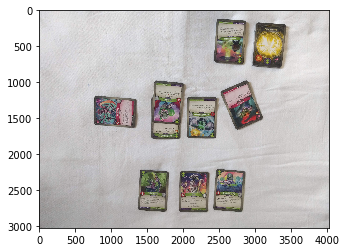

In [12]:
# READ IMAGE
# Reading and displaying is done with MATPLOTLIB, i.e. RGB coding is used
# CV2 uses BGR coding. Both is fine, as long we are consistent.
# kfimage = imread('..\\4Cards.jpg')
kfimage = imread('..\\manyCards.jpg')
figure()
imshow(kfimage)
print(kfimage[1350][1200])

%pwd

In [3]:
# DOWNSCALE IMAGE TO SAVE PROCESSING TIME
MIN_PER_AXIS = 500 # at least 500 pixels per axis
height, width = kfimage.shape[:2]
SCALE_FACT = MIN_PER_AXIS / min(height,width)
# NOTE: Cubic interpolation is slow, might need reconcideration for video apps
kfresized = cv2.resize(kfimage, None, fx=SCALE_FACT, fy=SCALE_FACT, interpolation=cv2.INTER_CUBIC)
print(kfresized.shape)

(500, 667, 3)


<IPython.core.display.Javascript object>


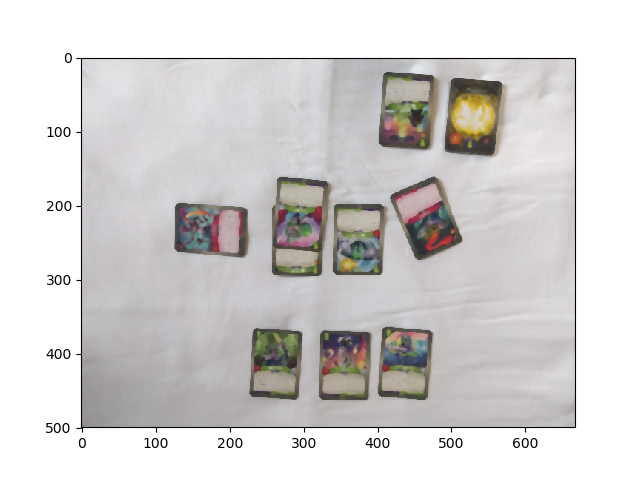

In [4]:
# USE BLURRING
# MEDIAN FILTERNIG preserves edges, but removes noise. Problem is: it's pretty slow, that's why downsizing might help here.
kfmedian = cv2.medianBlur(kfresized,5)

figure()
imshow(kfmedian)

Populating the interactive namespace from numpy and matplotlib


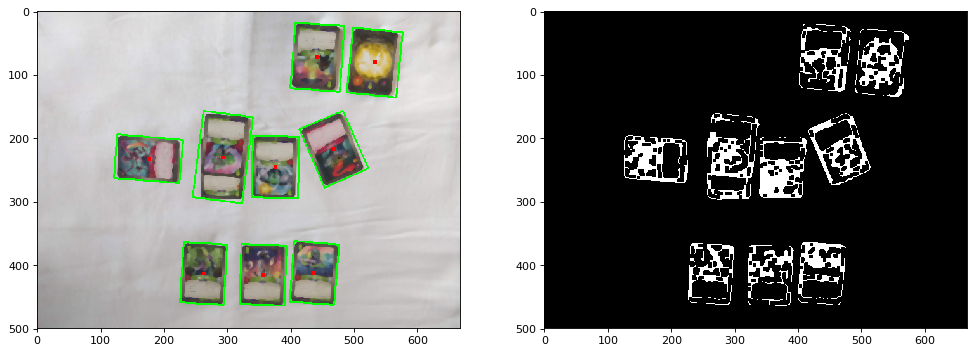

interactive(children=(IntSlider(value=91, description='par1', max=200, min=1, step=10), IntSlider(value=141, d…

In [5]:
# DETECT CARDS
# CANNY detector might work. However, it uses Gaussian-blur in-line, which might not be the best for our purposes:
# it smooths edges - we might want to use _only_ median filtering, see above. Shall we implement our own Canny detector?

%pylab inline
from ipywidgets import interact

def update(par1,par2):
    # Use CANNY for edge-detection right now. We might want to erode/dilate the mask later on.
    # kfgray = cv2.cvtColor(kfmedian,cv2.COLOR_RGB2GRAY)
    kfcanny = cv2.Canny(kfmedian,par1,par2)
    k_dilate = np.ones((5,5),np.uint8)
    # kfcanny = cv2.dilate(kfcanny,k_dilate,iterations = 1)
    kfcanny = cv2.morphologyEx(kfcanny, cv2.MORPH_CLOSE, k_dilate) # closing means "dilate than erode"

    # Since CANNY returns an NxMx1 array (black&white) we need to convert it into NxMx3
    kfcannyRGB = cv2.cvtColor(kfcanny,cv2.COLOR_GRAY2RGB)

    # Find contours and bouding rectangles on the edge-detected image
    (contours,_) = cv2.findContours(kfcanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Create new image to draw on
    kfedges = kfmedian.copy()
    rotRects = []
    for mycontour in contours:
        # BOUNDINGRECT: returns bounding rectangle without rotation
        # (x,y,w,h) = cv2.boundingRect(contour)
        # cv2.rectangle(kfmedian, (x,y), (x+w,y+h), (0,255,0), 2)
        # MINAREARECT: returns bounding rectangle with minimal area, i.e. it considers rotation. That's what we need.
        # cv2.minAreaRect() returns a tuple of ((x, y), (w, h), angle), where:
        #     x:     position of center along horizontal axis
        #     y:     position of center along vertical axis
        #     w:     size along horizontal axis (before rotation)
        #     h:     size along vertical axis (before rotation)
        #     angle: rotation around center in degree; negative: counter-clockwise, positive: clockwise
        myRotRect = cv2.minAreaRect(mycontour)
        # print(rotRect)
        mybox = cv2.boxPoints(myRotRect)
        mybox = numpy.int0(mybox)
        # mark centers:
        kfedges[round(myRotRect[0][1])-3:round(myRotRect[0][1])+3,round(myRotRect[0][0])-3:round(myRotRect[0][0])+3] = (255,0,0)
        # mark borders:
        cv2.drawContours(kfedges,[mybox], 0, (0,255,0), 2)
        if len(rotRects) == 0: # check if rotRects is empty or not
            rotRects = myRotRect
        else:
            rotRects = vstack((rotRects,myRotRect))
    
    figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
    subplot(1,2,1)
    imshow(kfedges)
    subplot(1,2,2)
    imshow(kfcannyRGB)
    
    # returning ROTRECTS for further processing
    return rotRects

rotRects = update(100,200)
interact(update,par1=(1,200,10),par2=(1,300,10));
# unfortunately I get this huge command line output about the contours, don't know how to get rid of it...

In [7]:
# FUNCTION TO CUT OUT AND ALIGN A REGION OF INTEREST FROM A LARGER FRAME (i.e. cut out a card and rotate to align horizontally/vertically)

# Rotate a highlighted region
def getSubImage(rect, src):
#     # ORIGINAL: press CTRL + / to uncomment
#     # Problem: the frame of interest might get rotated out of the new frame
#     # Get center, size, and angle from rect
#     center, size, theta = rect
#     # Convert to int 
#     center, size = tuple(map(int, center)), tuple(map(int, size))
#     # Get rotation matrix for rectangle
#     M = cv2.getRotationMatrix2D( center, theta, 1)
#     # Perform rotation on src image
#     dst = cv2.warpAffine(src, M, src.shape[:2])
#     out = cv2.getRectSubPix(dst, size, center)
    
    # UPDATED:
    # Solution to problem above: first shift frame to center frame of interest on the full frame, then do the rest
    # Get center, size, and angle from rect
    center, size, theta = rect
    # Convert to int 
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Center pic on frame of interest
    rows,cols,chans = src.shape
    xshift = cols/2 - center[0]
    yshift = rows/2 - center[1]
    M = float32([[1,0,xshift],[0,1,yshift]])
    src_shift = cv2.warpAffine(src,M,(cols,rows))
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D( (cols/2,rows/2), theta, 1) # rotate around center
    # Perform rotation on src_shift image
    dst = cv2.warpAffine(src_shift, M, src_shift.shape[:2])
    out = cv2.getRectSubPix(dst, size, (cols/2,rows/2)) # get frame around center of rotation, i.e. center of pic

#     # Plot for demo
#     figure()
#     subplot(1,3,1)
#     imshow(src,cmap='gray')
#     subplot(1,3,2)
#     imshow(src_shift,cmap='gray')
#     subplot(1,3,3)
#     imshow(dst,cmap='gray')

    return out

['tophist: ', 568, ' bottomhist: ', 303]
Picture is on the bottom


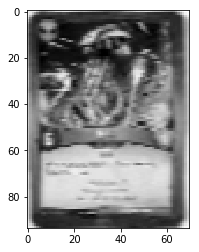

In [8]:
# EXTRACT INDIVIDUAL CARDS
# This part is now only implemented on a single card, for demonstration purposes only. Still operating on resized, blurred image.

# For example:
out = getSubImage(rotRects[0], kfresized.copy())

# Get orientation. I use the standard deviation of the grayscale image here:
outGray = cv2.cvtColor(out,cv2.COLOR_RGB2GRAY)
height,width = outGray.shape

# Display grayscale
# figure()
# imshow(outGray,cmap='gray')

# make sure it's upright
if (width > height):
    outGray = transpose(outGray)
    height,width = outGray.shape
    # modify rotation in CONTOURS by 90 degrees

# # Display upright picture
# figure()
# imshow(outGray,cmap='gray')

# Find out which region is the picture (i.e. decide on orientation of the card)
# Only Upgrades have the pic on the bottom, but those pics will be covered anyways
# Idea:
# - look at the center of the top and bottom half of the picture
# - blur reasonably (only to blur out text on text area)
# - look at histogram: text area should be homogenous
vmargin = round(height*0.1)
hmargin = [width*0.1,width*0.9]
hmargin = around(hmargin).astype(int)
vfifty  = round(height/2)
topGray = cv2.blur(outGray[vmargin:vfifty-vmargin,hmargin[0]:hmargin[1]],(10,10))
bottomGray = cv2.blur(outGray[vfifty+vmargin:-vmargin,hmargin[0]:hmargin[1]],(10,10))

# # Display top and bottom of card
# figure()
# subplot(1,2,1)
# imshow(topGray,cmap='gray')
# subplot(1,2,2)
# imshow(bottomGray,cmap='gray')

# Calculate metrics to decide on which part is which
# Perhaps this is an overkill: is there a simpler way?
tophist    = sort(histogram(topGray)[0])
bottomhist = sort(histogram(bottomGray)[0])
print(['tophist: ',sum(tophist[-1:]),' bottomhist: ',sum(bottomhist[-1:])])
if (sum(bottomhist[-1:]) < sum(tophist[-1:])):
    outGray = flipud(outGray)
    print('Picture is on the bottom')
    # modify rotation in CONTOURS by 180 degrees
else:
    print('Picture is on the top')

figure()
imshow(outGray,cmap='gray')

(420, 300)
(420, 300)
((2.1704786210841007, 1.1907599118599421), 0.39245230498137296)


<h1>Other stuff, not part of the processing flow</h1>

In [145]:
# SOME TRIES
# Get card from original picture
a = ((1,2),(3,4),5)
b = ((6,7),(8,9),10)
# d = [d,[a[0][0],a[0][1],a[1][0],a[1][1],a[2]]]
# init
# d = a
# d = vstack((d,b))
print(d)
print(d[0][0][1])

[[(1, 2) (3, 4) 5]
 [(6, 7) (8, 9) 10]
 [(6, 7) (8, 9) 10]]
2


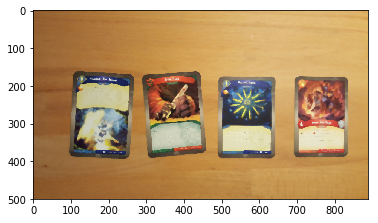

In [9]:
figure()
imshow(kfmedian)

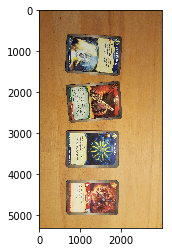

In [10]:
# Read image and display with OpenCV
cv_kfimage = cv2.imread('..\\4Cards.jpg')
# NOTE:
# CV2 uses BGR and MATPLOTLIB uses RGB representation by default
# Display it with MATPLOTLIB:
figure()
imshow(cv2.cvtColor(cv_kfimage,cv2.COLOR_BGR2RGB))
# Display it with CV2:
# cv2.imshow('KFimage',cv_kfimage)
# cv2.waitKey()
# cv2.destroyWindow('KFimage')

102


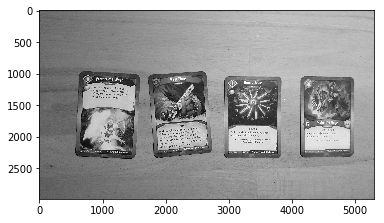

In [11]:
# Convert to grayscale
kfgray = cv2.cvtColor(kfimage,cv2.COLOR_RGB2GRAY)
figure()
imshow(kfgray,cmap='gray')
print(kfgray[0][0])

In [12]:
# Convert to floating point representation, as now it's uint8
kfgrayfloat = kfgray.astype(double)/255.0 # map to a range of 0-1